# Preparation

In [9]:
import torch
import torchvision
import math
import random
import time
import json
import os
import os.path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.mixture import GaussianMixture
from typing import Any, Callable, Optional, Tuple
# from google.colab import files
from PIL import Image

In [10]:
# !gdown https://drive.google.com/uc?id=1B0TqxV0bsQrmZYF1IHdNZnbmth5HivoJ
# !tar -xf /content/noisy-train-set.tar

torch.cuda.is_available()

True

In [27]:
class DS801Dataset(torchvision.datasets.vision.VisionDataset):

    def __init__(
            self,
            data_path: str,
            transform: Optional[Callable] = None,
    ) -> None:

        # load data
        self.data_path = data_path
        # list of file names: File name must be this string format "label-filename"
        self.file_list = os.listdir(os.path.join(data_path, "imgs"))
        label_map_path = os.path.join(data_path, 'data-labels.json')
        self.label_map = json.load(open(label_map_path))


        self.transform = transform


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """

        image_path = os.path.join(self.data_path, 'imgs', self.file_list[index])

        # load image
        img = Image.open(image_path).convert('RGB')
        
        #saving the image name
        img_name = self.file_list[index].split('.')[0]
        # parsing label
        target = self.label_map[img_name]

        if self.transform is not None:
            img = self.transform(img)

        return index, img, torch.tensor(target), img_name


    def __len__(self) -> int:
        return len(self.file_list)


# the function to transform image to tensors
def make_transforms():

    # we won't apply any data augmentation during the training pipeline, while you need to add augmented images into the datasets
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(size = 255),
        torchvision.transforms.CenterCrop(size = 240),
        # ToTensor applies standardization automatically when converting to Tensors.
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
    ])


def build(data_path):
    return DS801Dataset(data_path=data_path, transform=make_transforms())

def compute_embedding(train_loader, model):
    embeddings = None
    one_hot_labels = None
    indices = None
    
    for indxs, imgs, lbls, _ in train_loader:
        imgs, lbls = imgs.to(_device), lbls.to(_device)
        outputs = model(imgs).squeeze(2, 3)
        if embeddings is None:
            embeddings = outputs.detach().cpu().numpy()
            one_hot_labels = lbls.detach().cpu().numpy()
            indices = indxs.detach().cpu().numpy()
            
        else:
            embeddings = np.concatenate((embeddings, outputs.detach().cpu().numpy()), axis = 0)
            one_hot_labels = np.concatenate((one_hot_labels, lbls.detach().cpu().numpy()), axis = 0)
            indices = np.concatenate((indices, indxs.detach().cpu().numpy()), axis = 0)

    class_labels = np.argmax(one_hot_labels, axis=1)

    print("Dimensions of embeddings:", embeddings.shape)
    print("Dimensions of labels:", class_labels.shape)
    print("Dimensions of indices:", indices.shape)

    return indices, embeddings, class_labels

def compute_class_averages(embeddings, class_labels):
    embedding_averages = {i: [] for i in range(_num_classes)}

    for i in range(_num_classes):
        indexes = np.where(class_labels == i)
        embedding_averages[i] = np.mean(embeddings[indexes], axis=0)

    return embedding_averages

def compute_distances(indices, embeddings, class_labels, embedding_averages):
    embed_dataset = torch.utils.data.TensorDataset(torch.tensor(indices),
                                                   torch.tensor(embeddings),
                                                   torch.tensor(class_labels)
                                                   )

    embed_loader = torch.utils.data.DataLoader(embed_dataset,
                                               batch_size=_batch_size,
                                               shuffle=False,
                                               drop_last=False,
                                               num_workers=_num_worders)

    dist_euclid = []
    dist_cos = []
    indexes = []
    labels = []
    
    for indxs, embds, lbls,_ in embed_loader:
        for idx, emb, lbl in zip(indxs, embds, lbls):
            emb = emb.detach().cpu()
            lbl = lbl.item()
            avg = embedding_averages[lbl]
            lbl = [lbl]
            idx = [idx.item()]

            euc = [np.linalg.norm(emb - avg)]
            cos = [np.dot(emb.flatten(), avg.flatten()) / (np.linalg.norm(emb.flatten()) * np.linalg.norm(avg.flatten()))]

            if len(dist_euclid) == 0:
                dist_euclid = euc
                dist_cos = cos
                indexes = idx
                labels = lbl
                
            else:
                dist_euclid = np.concatenate((dist_euclid, euc), axis = 0)
                dist_cos = np.concatenate((dist_cos, cos), axis = 0)
                indexes = np.concatenate((indexes, idx), axis = 0)
                labels = np.concatenate((labels, lbl), axis = 0)

    print("Dimension of euclidean distance:", dist_euclid.shape)
    print("Dimension of cosine similarity:", dist_cos.shape)
    print("Dimension of indices:", indexes.shape)
    print("Dimension of labels:", labels.shape)
    return indexes, dist_euclid, dist_cos, labels

def save_distances(indexes, dist_euclid, dist_cos, labels):
    df = pd.DataFrame({'indexes': indexes,
                       'label': labels,
                       'dist_euclid': dist_euclid,
                       'dist_cos': dist_cos,
                   })
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    df.to_csv('distances_{}.csv'.format(timestamp), index=False)
    return df

def find_outliers(df, sig):
    IQR_euc = df['dist_euclid'].quantile(0.75) - df['dist_euclid'].quantile(0.25)
    upper_bound_euc = df['dist_euclid'].quantile(0.75) + sig * IQR_euc
    outliers_euc = df[df['dist_euclid'] >= upper_bound_euc].indexes

    IQR_cos = df['dist_cos'].quantile(0.75) - df['dist_cos'].quantile(0.25)
    lower_bound_cos = df['dist_cos'].quantile(0.25) - sig * IQR_cos
    outliers_cos = df[df['dist_cos'] <= lower_bound_cos].indexes

    outliers = np.union1d(outliers_euc, outliers_cos)

    return outliers

def remove_outliers(outliers, data_path):
    file_list = os.listdir(os.path.join(data_path, "imgs"))
    label_map_path = os.path.join(data_path, 'data-labels.json')
    label_map = json.load(open(label_map_path))

    for index in outliers:
        os.remove(os.path.join(data_path, "imgs", file_list[index]))
        img_key = file_list[index].split('.')[0]
        if img_key in label_map:
            label_map.pop(img_key)
    with open(label_map_path, 'w') as file:
        json.dump(label_map, file)

def list_outliers(outliers, data_path):
    file_list = os.listdir(os.path.join(data_path, "imgs"))
    label_map_path = os.path.join(data_path, 'data-labels.json')
    label_map = json.load(open(label_map_path))

    img_keys = {}
    for index in outliers:
        img_key = file_list[index].split('.')[0]
        if img_key in label_map:
            img_keys[index] = img_key

    return img_keys

def outliers_handling(data_path, model, _device, _batch_size, _num_worders, _num_classes, auto_delete = True, sig = 1.5):
    train_data = build(data_path)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=_batch_size,
                                               shuffle=False,
                                               drop_last=False,
                                               num_workers=_num_worders)

    torch.cuda.empty_cache()
    print("Computing embeddings...")
    indices, embeddings, class_labels = compute_embedding(train_loader, model)

    torch.cuda.empty_cache()
    print("Computing class averages...")
    embedding_averages = compute_class_averages(embeddings, class_labels)

    torch.cuda.empty_cache()
    print("Computing distances...")
    indexes, dist_euclid, dist_cos, labels = compute_distances(indices, embeddings, class_labels, embedding_averages)

    torch.cuda.empty_cache()
    df = save_distances(indexes, dist_euclid, dist_cos, labels)

    print("Finding and removing outliers...")
    outliers = find_outliers(df, sig)

    img_keys = list_outliers(outliers, data_path)

    if auto_delete:
        remove_outliers(outliers, data_path)

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    np.save('outliers_{}.npy'.format(timestamp), outliers)
    print("Removed {} outliers".format(len(outliers)))
    return img_keys

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [12]:
# data_path = "/content/noisy-train-set"
data_path = "./noisy-train-set/train-set"
data = DS801Dataset(data_path=data_path, transform=make_transforms())
print("# training images:", len(data))

# training images: 31848


In [13]:
_device = "cuda"
_batch_size = 48
_num_worders = 2
label_map = {
    0 : 'Cat',
    1 : 'Lynx',
    2 : 'Wolf',
    3 : 'Coyote',
    4 : 'Cheetah',
    5 : 'Jaguar',
    6 : 'Chimpanzee',
    7 : 'Orangutan',
    8 : 'Hamster',
    9 : 'Guinea Pig'
}
_num_classes = 10

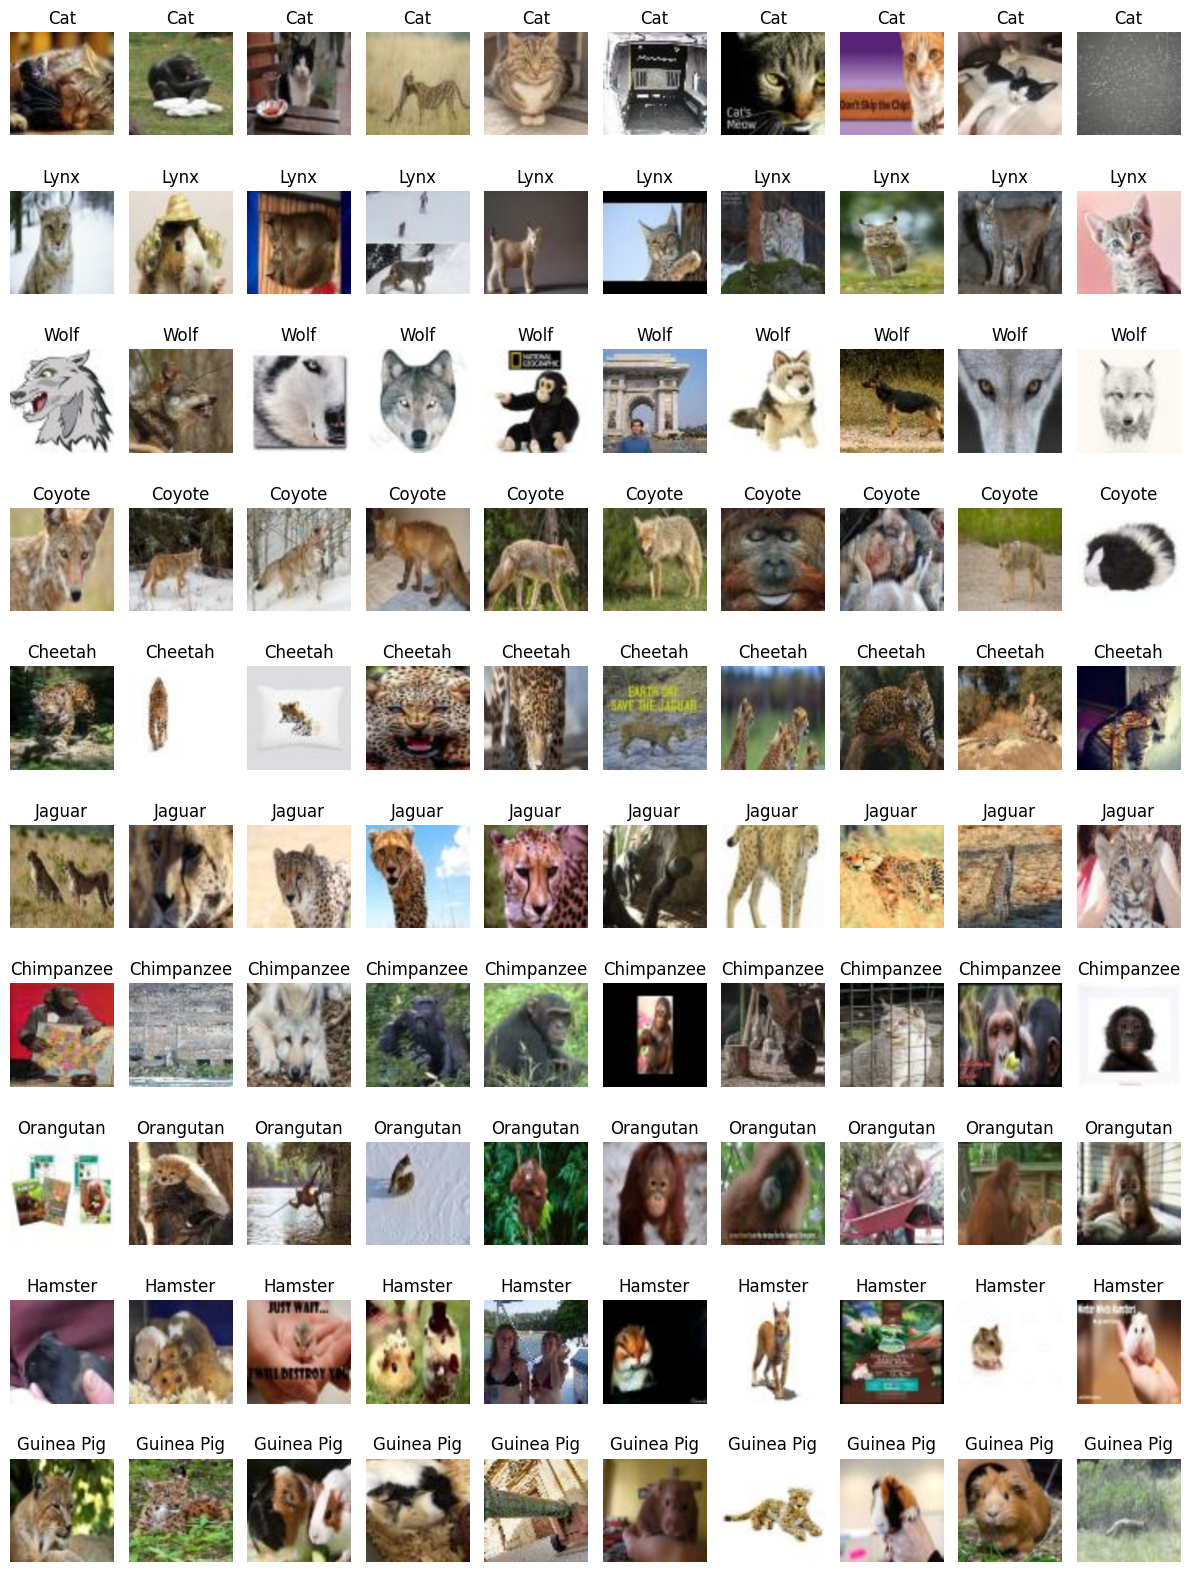

In [14]:
examples = {i: [] for i in range(_num_classes)}
n_examples = 10
example_data = DS801Dataset(data_path=data_path,
                            transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Resize(size = 255),
                                        torchvision.transforms.ToTensor()
                            ]))

for index, x, i in example_data:
    i = (i == 1).nonzero(as_tuple=True)[0].item()
    if all([len(ex) == n_examples for ex in examples.values()]):
        break
    if len(examples[i]) < n_examples:
        examples[i].append(x)

figure = plt.figure(figsize=(12, 16))
cols, rows = n_examples, _num_classes
label = 0
for i in range(1, cols * rows + 1):
    img = examples[label][i % cols]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    if i % cols == 0:
        label += 1
plt.show()

# Outlier Handling

In [6]:
model = torchvision.models.efficientnet_b1(weights = "DEFAULT")
model = torch.nn.Sequential(*list(model.children())[:-1])   #  remove classifier layer to get the embedding
model.to(_device)
model.eval()

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
outliers = {}
rounds = 3

for i in range(rounds):
    outlier = outliers_handling(data_path, model, _device, _batch_size, _num_worders, _num_classes, auto_delete = True, sig = 1.5) # +- sig * IQR
    for idx in outlier.keys():
        outliers[str(idx)] = outlier[idx]

print("Number of outliers:", len(outliers))
print("Outliers:", outliers)

with open( "/content/outliers.json", 'w') as file:
    json.dump(outliers, file)

In [37]:
outliers = {'63': 'img_344c932c-5260-4d80-846a-2b730ad5591e',
            '1282': 'img_1b5e87a6-e2e8-41bf-9853-8936dc47357f',
            '1450': 'img_153d33dd-47cf-44ff-8031-804cc4355163',
            '2009': 'img_61a2fb67-bf2e-4563-a417-2cee57bd3263',
            '2606': 'img_e6086a70-d80b-4be6-bcce-67fb0579545f',
            '5026': 'img_95fbd894-b67e-4969-b603-87d1e8960737',
            '5130': 'img_e90a4ae1-0f04-43f0-8295-506b279397b9',
            '5570': 'img_e481222f-727e-4fcb-8c50-8d6af5457ade',
            '5576': 'img_82a99323-fd92-45d9-965b-57f0af493af7',
            '5607': 'img_bdfc7cef-7fbc-4fd9-8ead-02fe6174c265',
            '6311': 'img_b073b404-c870-4198-981c-3265f0660f25',
            '6608': 'img_02d8cdc5-10c1-4bcd-abf3-0b724ab5afef',
            '6686': 'img_9ba1dec4-12b1-4d5e-b464-925756d28735',
            '7235': 'img_2b780dde-7964-4ecd-92b7-b603c3a713be',
            '7687': 'img_e865b2e9-c1ff-4bad-91f7-1f27f5534247',
            '8280': 'img_20d2e198-7f31-4e78-8c3c-39280d782cbf',
            '8527': 'img_81f1bb63-38ff-4a8b-9a05-a522437ca107',
            '9860': 'img_eebda25d-7606-4bc3-828f-244c8fce3721',
            '10153': 'img_bd31c982-02de-4dbf-aafb-84f5bd2d43d4',
            '13061': 'img_d653b7e0-d3bb-4bf3-bff4-6a972943c91b',
            '13249': 'img_b3f57b13-8fa6-472a-bc42-630069610032',
            '14906': 'img_be20f5d9-2587-44f1-870b-3c77b169969d',
            '16179': 'img_72b339b6-74ba-4334-a97d-7d709e1b1449',
            '16528': 'img_d274ff82-d3ae-4c18-aa94-d236833b9933',
            '17448': 'img_240dcae7-7c33-4cdf-8aee-e2678cf9e7af',
            '17609': 'img_3ef1ac84-c937-433f-918c-18f60471ffc3',
            '17860': 'img_6a45e62a-1437-4a70-b28c-04b863b06f34',
            '20344': 'img_32db3cdc-88d1-4e63-b121-d1f5730de941',
            '20739': 'img_a547c45f-e8c3-40dd-9d61-60b226e270a8',
            '21097': 'img_78a3a8c9-f0d3-4edc-b8ba-5b04d0d19a46',
            '21315': 'img_fdf000fb-59bb-4d82-a762-aefda0035f46',
            '22756': 'img_5cf369ad-47a7-41b6-b4d5-4daa9d206fbe',
            '22930': 'img_74ed4bcb-9495-44ee-8eb4-ca7d4db2d56d',
            '23177': 'img_fb006819-3c31-4702-a770-b66350d300a2',
            '25403': 'img_5c936d28-e20f-4e67-a746-a8d89e13d723',
            '25717': 'img_397319af-94c0-4c72-87da-89ae4fe73398',
            '25940': 'img_dc8685a3-4b2c-408d-8d87-c9764be57786',
            '26521': 'img_0ce34927-ab06-406b-8e6e-aa4cfd70554c',
            '29081': 'img_b05f67ab-fe22-4460-9995-f67185da260e',
            '29383': 'img_25061fc2-b745-4d04-9b6a-768ad4b79f36',
            '29426': 'img_5bda931a-f78f-4e8d-bb6b-22506b807c31',
            '29518': 'img_71fa6e08-045a-472b-b00d-4dd8ff5f9143',
            '30026': 'img_5d4920d7-a2cf-4eb2-aab3-e2d43f64ba9a',
            '30958': 'img_4bb7a616-63b1-471f-aa6b-9321c0769649',
            '31209': 'img_f03b0282-1289-4e28-8610-079b507fb031',
            '13680': 'img_67369e91-5e6f-4656-b8c3-b0eae6e0827b'}

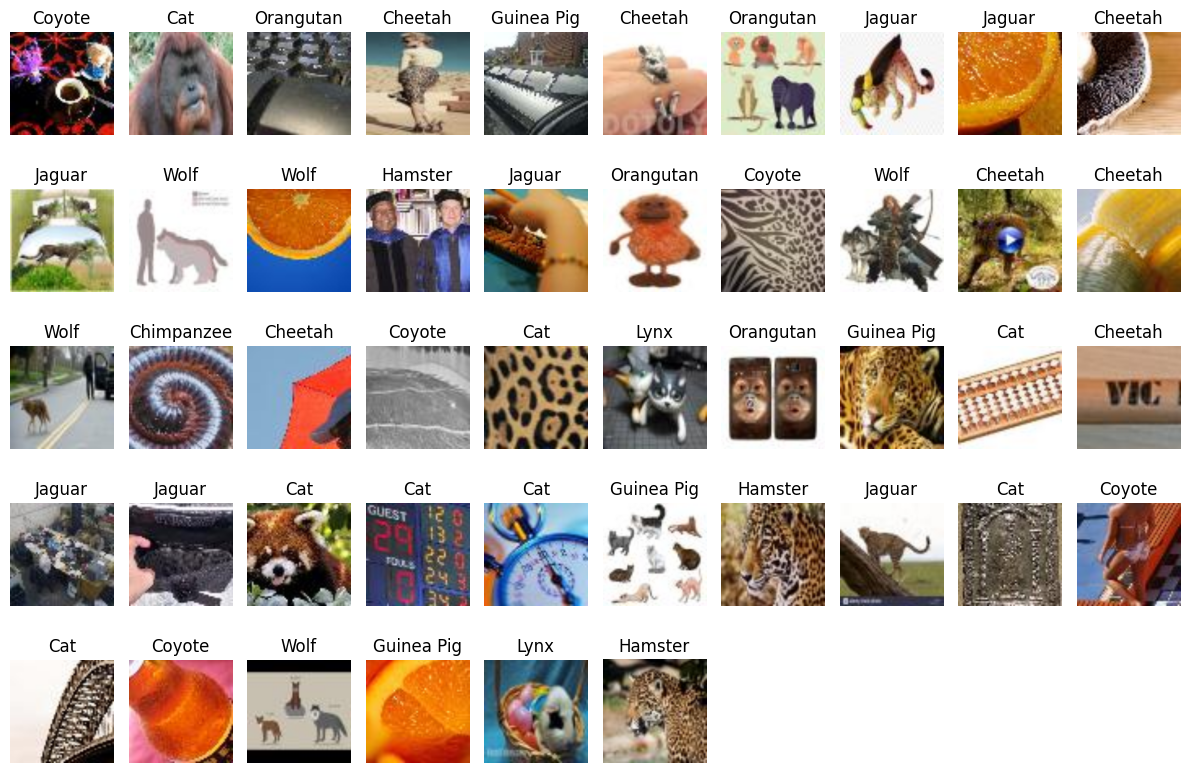

In [50]:
#MAKE SURE that we use the original train dataset (not the one that outliers have been removed) because we want to display outlier images here!
original_path = "./noisy-train-set/noisy-train-set"

example_data = DS801Dataset(data_path=original_path,
                            transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Resize(size = 255),
                                        torchvision.transforms.ToTensor()
                            ]))

outlier_indices = []
for idx, (index, img, label, file_name) in enumerate(example_data):
    if file_name in outliers.values():
        outlier_indices.append(idx)

figure = plt.figure(figsize=(12, 8))
cols, rows = 10, 5
counter = 1
for i in outlier_indices:
    if counter > cols*rows:
        break
    name = example_data[i][3]
    img = example_data[i][1]
    label = torch.argmax(example_data[i][2]).item()
    figure.add_subplot(rows, cols, counter)
    plt.title(label_map[label])
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    counter += 1
            
plt.show()

# Dealing with Noisy Labels

## Sample Selection

In [ ]:
model = torchvision.models.efficientnet_b1(weights = "DEFAULT")
model.to(_device)
model.eval()

train_data = build(data_path)

criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion.to(_device)
criterion.eval()

In [ ]:
#Accumulate loss values for all examples
losses = np.zeros(len(train_data), dtype=np.float32)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=_batch_size,
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=_num_worders)

# val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
#                                            shuffle=False,
#                                            drop_last=False,
#                                            num_workers=num_workers)

for ids, inputs, noisy_labels, _ in train_loader:
    inputs, noisy_labels = inputs.to(_device), noisy_labels.to(_device)
    
    # inference
    outputs = model(inputs)

    # compute loss per example
    loss = criterion(outputs, noisy_labels)
    np_loss = loss.detach().cpu().numpy()

    # accumulate all the losses
    for idx, id in enumerate(ids):
        # log-loss is better than the original loss, since it helps to make distribution to have two bell shapes
        losses[id] = math.log2(np_loss[idx])

bins = np.linspace(-4, 3, 100)
plt.hist(losses, bins, alpha=0.5, label='mixed', density=True)
plt.title('Loss distribution of all examples')
plt.legend()
plt.show()

In [ ]:
#Fit 2 GMMs to the loss values
reshaped_losses = losses.reshape((-1, 1)) # [x, y, ..] -> [[x], [y], ...]

gmm = GaussianMixture(n_components=2).fit(reshaped_losses)
means = gmm.means_

# The component at the left side is the clean one
clean_comp = 0 if means[0] < means[1] else 1

# Probability of belonging to the clean component
probs = gmm.predict_proba(reshaped_losses)

est_clean_losses = []
est_noise_losses = []
for idx, loss in enumerate(losses):
    random_val = random.random() # coin flipping with random value to determine the label type
    if random_val <= probs[idx][clean_comp]:
        est_clean_losses.append(loss)
    else:
        est_noise_losses.append(loss)

plt.hist(est_clean_losses, bins, alpha=0.5, label='Estimated clean', density=True)
plt.hist(est_noise_losses, bins, alpha=0.5, label='Estimated noise', density=True)
plt.title('Loss distribution with estimated labels by GMMs')
plt.legend()
plt.show()

In [ ]:
#Select examples with P(Clean | Loss) > threshold
threshold = 0.5 # for clean component

selected_set = []
for idx, prob in enumerate(probs):
    if prob[clean_comp] > threshold:
        selected_set.append(idx)

estimated_num_clean = 0
for idx in selected_set:
    if train_data.true_targets[idx] == train_data.targets[idx]:
        estimated_num_clean += 1

print("# of Total samples:", len(train_data.targets))
print("# of selected clean samples:", estimated_num_clean)

# evaluate the selection Recall and Precision.
# Recall: how many clean samples are selected out of all clean samples?
# Precision: how precisely we select clean samples out of our selections?
num_clean = len(train_data) * (1.0 - train_data)
num_selected_clean = len(selected_set)
precision = estimated_num_clean / num_selected_clean
recall = estimated_num_clean / num_clean

# The precision and Recall are very high, indicating that GMM based sample selection is very effective!
print("Recall:", recall)
print("Precision:", precision)

In [ ]:
#Train model from scratch with the selected samples
clean_model = torchvision.models.efficientnet_b1(weights = "DEFAULT")
clean_model.to(_device)

epochs = 30

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clean_model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

## Prepare the look-up table for the selected set
selected_set = set(selected_set)
##########

print("Train with selected clean examples")
for epoch in range(epochs):

  clean_model.train()
  criterion.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for indices, inputs, labels,_ in train_loader:

      ##################################################
      # select the examples only in the selected set
      clean_inputs = []
      clean_labels = []

      for i in range(_batch_size):
        if indices[i].item() in selected_set:
          clean_inputs.append(inputs[i])
          clean_labels.append(labels[i])

      clean_inputs = torch.stack(clean_inputs, dim=0)
      clean_labels = torch.stack(clean_labels, dim=0)
      ##################################################

      clean_inputs = clean_inputs.to(_device)
      clean_labels = clean_labels.to(_device)
      outputs = clean_model(clean_inputs)
      loss = criterion(outputs, clean_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      train_accuracy += accuracy(outputs, clean_labels)[0].item()

  # # test
  # clean_model.eval()
  # criterion.eval()
  # test_accuracy = 0.0
  # test_accuracy = 0.0
  # 
  # for idx, inputs, labels,_ in val_loader:
  # 
  #     inputs = inputs.to(_device)
  #     labels = labels.to(_device)
  #     outputs = clean_model(inputs)
  #     test_accuracy += accuracy(outputs, labels)[0].item()

  lr_scheduler.step()
  print("[ Epoch", epoch, "] train loss:", '%.4f' % (train_loss / len(train_loader)), ",",
        "train accuracy:", '%.4f' % (train_accuracy / len(train_loader)),
        # ",", "test accuracy:", '%.4f' % (test_accuracy / len(test_loader))
        )


## Relabeling

In [ ]:
early_stop_epochs = 3
total_epochs = 30

clean_model_w_relabeling = torchvision.models.efficientnet_b1(weights = "DEFAULT")
clean_model_w_relabeling.to(_device)

In [ ]:
#Training on noisy data until early stop epoch
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clean_model_w_relabeling.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

print("Train with noisy data by early stopping")
for epoch in range(early_stop_epochs):

  clean_model_w_relabeling.train()
  criterion.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for indices, inputs, labels, _ in train_loader:

      # use the noisy data for training
      inputs = inputs.to(_device)
      labels = labels.to(_device)
      outputs = clean_model_w_relabeling(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      train_accuracy += accuracy(outputs, labels)[0].item()

  # # test
  # clean_model_w_relabeling.eval()
  # criterion.eval()
  # test_accuracy = 0.0
  # test_accuracy = 0.0
  # 
  # for idx, inputs, labels, _ in val_loader:
  # 
  #     inputs = inputs.to(_device)
  #     labels = labels.to(_device)
  #     outputs = clean_model_w_relabeling(inputs)
  #     test_accuracy += accuracy(outputs, labels)[0].item()

  lr_scheduler.step()
  print("[ Epoch", epoch, "] train loss:", '%.4f' % (train_loss / len(train_loader)), ",",
        "train accuracy:", '%.4f' % (train_accuracy / len(train_loader)),
        # ",", "test accuracy:", '%.4f' % (test_accuracy / len(val_loader))
        )

In [ ]:
#Train on relabeled data for the rest epochs
print("Train with relabeled data by the model (at early stop point, but evolves gradually)")

confidence_threshold = 0.8

for epoch in range(early_stop_epochs, total_epochs, 1):

  clean_model_w_relabeling.train()
  criterion.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for indices, inputs, labels, _ in train_loader:

      # use the relabeled data for training
      inputs = inputs.to(_device)
      labels = labels.to(_device)
      outputs = clean_model_w_relabeling(inputs)

      ########## Re-labeling #############
      # get prediction probability (confidence)
      probs = torch.nn.functional.softmax(outputs, dim=1)
      confidence, pred_labels = torch.max(probs, 1)
      pred_labels.to(_device)

      # make a mask: True: high conf / False: low conf
      confidence_mask = confidence > confidence_threshold
      confidence_mask.to(_device)

      #re-labeling: only re-label the samples with high prediction confidence (we are certain!)
      new_labels = labels * ~confidence_mask + pred_labels * confidence_mask
      ####################################

      # update with the predicted labels as the target
      loss = criterion(outputs, new_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      train_accuracy += accuracy(outputs, new_labels)[0].item()

  # # test
  # clean_model_w_relabeling.eval()
  # criterion.eval()
  # test_accuracy = 0.0
  # test_accuracy = 0.0
  # 
  # for idx, inputs, labels,_ in val_loader:
  # 
  #     inputs = inputs.to(_device)
  #     labels = labels.to(_device)
  #     outputs = clean_model_w_relabeling(inputs)
  #     test_accuracy += accuracy(outputs, labels)[0].item()

  lr_scheduler.step()
  print("[ Epoch", epoch, "] train loss:", '%.4f' % (train_loss / len(train_loader)), ",",
        "train accuracy:", '%.4f' % (train_accuracy / len(train_loader)),
        # ",", "test accuracy:", '%.4f' % (test_accuracy / len(val_loader))
        )


## Sample Selection + Relabeling

In [ ]:
early_stop_epochs = 3
total_epochs = 30

clean_model_w_relabeling = torchvision.models.efficientnet_b1(weights = "DEFAULT")
clean_model_w_relabeling.to(_device)

In [ ]:
#Training on noisy data until early stop epoch
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clean_model_w_relabeling.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

## Prepare the look-up table for the selected set
selected_set = set(selected_set)
##########

print("Train with noisy data by early stopping")
for epoch in range(early_stop_epochs):

  clean_model_w_relabeling.train()
  criterion.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for indices, inputs, labels, _ in train_loader:
      
      ##################################################
      # select the examples only in the selected set
      clean_inputs = []
      clean_labels = []

      for i in range(_batch_size):
        if indices[i].item() in selected_set:
          clean_inputs.append(inputs[i])
          clean_labels.append(labels[i])

      clean_inputs = torch.stack(clean_inputs, dim=0)
      clean_labels = torch.stack(clean_labels, dim=0)
      ##################################################

      # use the noisy data for training
      inputs = clean_inputs.to(_device)
      labels = clean_labels.to(_device)
      outputs = clean_model_w_relabeling(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      train_accuracy += accuracy(outputs, labels)[0].item()

  # # test
  # clean_model_w_relabeling.eval()
  # criterion.eval()
  # test_accuracy = 0.0
  # test_accuracy = 0.0
  # 
  # for idx, inputs, labels, _ in val_loader:
  # 
  #     inputs = inputs.to(_device)
  #     labels = labels.to(_device)
  #     outputs = clean_model_w_relabeling(inputs)
  #     test_accuracy += accuracy(outputs, labels)[0].item()

  lr_scheduler.step()
  print("[ Epoch", epoch, "] train loss:", '%.4f' % (train_loss / len(train_loader)), ",",
        "train accuracy:", '%.4f' % (train_accuracy / len(train_loader)),
        # ",", "test accuracy:", '%.4f' % (test_accuracy / len(val_loader))
        )

In [ ]:
#Train on relabeled data for the rest epochs
print("Train with relabeled data by the model (at early stop point, but evolves gradually)")

confidence_threshold = 0.8

## Prepare the look-up table for the selected set
selected_set = set(selected_set)
##########

for epoch in range(early_stop_epochs, total_epochs, 1):

  clean_model_w_relabeling.train()
  criterion.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for indices, inputs, labels, _ in train_loader:
      
      ##################################################
      # select the examples only in the selected set
      clean_inputs = []
      clean_labels = []

      for i in range(_batch_size):
        if indices[i].item() in selected_set:
          clean_inputs.append(inputs[i])
          clean_labels.append(labels[i])

      clean_inputs = torch.stack(clean_inputs, dim=0)
      clean_labels = torch.stack(clean_labels, dim=0)
      ##################################################

      # use the relabeled data for training
      inputs = clean_inputs.to(_device)
      labels = clean_labels.to(_device)
      outputs = clean_model_w_relabeling(inputs)

      ########## Re-labeling #############
      # get prediction probability (confidence)
      probs = torch.nn.functional.softmax(outputs, dim=1)
      confidence, pred_labels = torch.max(probs, 1)
      pred_labels.to(_device)

      # make a mask: True: high conf / False: low conf
      confidence_mask = confidence > confidence_threshold
      confidence_mask.to(_device)

      #re-labeling: only re-label the samples with high prediction confidence (we are certain!)
      new_labels = labels * ~confidence_mask + pred_labels * confidence_mask
      ####################################

      # update with the predicted labels as the target
      loss = criterion(outputs, new_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      train_accuracy += accuracy(outputs, new_labels)[0].item()

  # # test
  # clean_model_w_relabeling.eval()
  # criterion.eval()
  # test_accuracy = 0.0
  # test_accuracy = 0.0
  # 
  # for idx, inputs, labels,_ in val_loader:
  # 
  #     inputs = inputs.to(_device)
  #     labels = labels.to(_device)
  #     outputs = clean_model_w_relabeling(inputs)
  #     test_accuracy += accuracy(outputs, labels)[0].item()

  lr_scheduler.step()
  print("[ Epoch", epoch, "] train loss:", '%.4f' % (train_loss / len(train_loader)), ",",
        "train accuracy:", '%.4f' % (train_accuracy / len(train_loader)),
        # ",", "test accuracy:", '%.4f' % (test_accuracy / len(val_loader))
        )


In [ ]:
print("New labels: ", new_labels)
print("Selected set: ", selected_set)